In [4]:
#!pip install hyperopt

In [22]:
from xgboost import XGBClassifier
from hyperopt import Trials, fmin, tpe, space_eval, STATUS_OK, hp
from sklearn.model_selection import StratifiedKFold

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [7]:
import shap
shap.initjs()

In [8]:
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Primary_Bank')
df = dataset.to_pandas_dataframe()

In [9]:
pd.set_option('max_columns', None) #display all columns
#pd.reset_option(“max_columns”) #to return to default

In [6]:
#df.head()

<AxesSubplot:title={'center':'New_Primary_Bank_Flag'}, ylabel='New_Primary_Bank_Flag'>

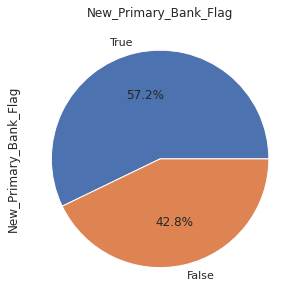

In [10]:
df['New_Primary_Bank_Flag'].value_counts().plot(kind = 'pie',y = 'New_Primary_Bank_Flag',figsize=(5, 5),title = 'New_Primary_Bank_Flag',autopct='%1.1f%%')


In [11]:
df = df.drop(columns = ['Customer_ID','Year','Month','Legal_Person', 'Active_Customer', 'Priority_Segment',	'Primary_Bank','Group_Sales_Group_Code'])

In [12]:
def binF(x):
    if x is False:
        z = 0
    elif math.isnan(x):
        z = 0
    else:
        z =1
    return z

In [13]:
df['New_Primary_Bank_Flag'] = df['New_Primary_Bank_Flag'].apply(binF)

In [14]:
#dummy variables
for col in df.columns:       
       if df[col].dtypes=='object':
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])
    

In [15]:
for col in df.columns:       
       if df[col].dtypes=='datetime64[ns]':
            df = df.drop(columns = col)


In [16]:
def replace_gt(x):
    x = x.replace('<=','le ')
    x = x.replace('>=','ge')
    x = x.replace('>','gt ')
    x = x.replace('<','lt ')
    return x

In [17]:
df.columns = [replace_gt(x) for x in df.columns]

In [18]:
df.head()

,SB_Customer,Total_Funds_Balances_Avg_1M,Total_Deposits_Balances_Avg_1M,Total_Loans_Balances_OutStanding_1M,Total_Deposits_All_Beneficieries_Balances_Avg_1M,Total_Funds_All_Beneficieries_Balances_Avg_1M,Bucket_Max_1M,Bucket_Max_1Y,Bucket_Months_Count_1Y,Days_Since_Last_Transaction,Age,POS_Balance_Sum_1Y,Checks_Issued_Last_1Y_Num,Checks_Issued_Last_1Y_Amount,Checks_Issued_MaxAmount_1Y,Checks_Issued_DaysSince_1Y,Remmitances_Out_GR_Num_Sum_1Y,Remmitances_Out_GR_Amount_Sum_1Y,Remmitances_Out_GR_Amount_Max_1Y,Remmitances_Out_GR_DaysSince_1Y,Remmitances_Out_nonGR_Num_Sum_1Y,Remmitances_Out_nonGR_Amount_Sum_1Y,Remmitances_Out_nonGR_Amount_Max_1Y,Remmitances_Out_nonGR_DaysSince_1Y,Remmitances_In_GR_Num_Sum_1Y,Remmitances_In_GR_Amount_Sum_1Y,Remmitances_In_GR_1Y_Amount_Max_1Y,Remmitances_In_GR_DaysSince_1Y,Remmitances_In_nonGR_Num_Sum_1Y,Remmitances_In_nonGR_Amount_Sum_1Y,Remmitances_In_nonGR_Amount_Max_1Y,Remmitances_In_nonGR_DaysSince_1Y,Rescheduling_Flag,Epistofi_Purchases_Num_Sum_6M,Epistofi_Points_Amount_Sum_6M,Epistofi_Redeemed_Amount_Sum_6M,Epistofi_Redeemed_Amount_Max_6M,Epistofi_Redemptions_Num_Sum_6M,SafeBox_active,CC_BasicNeeds_Purchases_Num_Sum_6M,CC_BasicNeeds_Purchases_Amount_Sum_6M,CC_BasicNeeds_Purchases_Amount_Max_6M,CC_HouseNeeds_Purchases_Num_Sum_6M,CC_HouseNeeds_Purchases_Amount_Sum_6M,CC_HouseNeeds_Purchases_Amount_Max_6M,CC_PersonalNeeds_Purchases_Num_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Max_6M,DC_BasicNeeds_Purchases_Num_Sum_6M,DC_BasicNeeds_Purchases_Amount_Sum_6M,DC_BasicNeeds_Purchases_Amount_Max_6M,DC_HouseNeeds_Purchases_Num_Sum_6M,DC_HouseNeeds_Purchases_Amount_Sum_6M,DC_HouseNeeds_Purchases_Amount_Max_6M,DC_PersonalNeeds_Purchases_Num_Sum_6m,DC_PersonalNeeds_Purchases_Amount_Sum_6M,DC_PersonalNeeds_Purchases_Amount_Max_6M,Total_Funds_Balance_Min_Ever,Total_Funds_Balance_Max_Ever,Total_Trans_Num_Sum_6M,Total_Trans_Amount_Sum_6M,Total_Trans_Days_Count_6M,Credit_Trans_Num_Sum_6M,Credit_Trans_Amount_Sum_6M,Credit_Trans_Days_Count_6M,Debit_Trans_Num_Sum_6M,Debit_Trans_Amount_Sum_6M,Debit_Trans_Days_Count_6M,Branch_Trans_Num_Sum_6M,Branch_Trans_Amount_Sum_6M,Branch_Trans_Days_Count_6M,ATM_Trans_Num_Sum_6M,ATM_Trans_Amount_Sum_6M,ATM_Trans_Days_Count_6M,Phone_Trans_Num_Sum_6M,Phone_Trans_Amount_Sum_6M,Phone_Trans_Days_Count_6M,EB_Trans_Num_Sum_6M,EB_Trans_Amount_Sum_6M,EB_Trans_Days_Count_6M,APS_Trans_Num_Sum_6M,APS_Trans_Amount_Sum_6M,APS_Trans_Days_Count_6M,LivePay_Trans_Num_Sum_6M,LivePay_Trans_Amount_Sum_6M,LivePay_Trans_Days_Count_6M,Payments_Trans_Num_Sum_6M,Payments_Trans_Amount_Sum_6M,Payments_Trans_Days_Count_6M,Remittance_Trans_Num_Sum_6M,Remittance_Trans_Amount_Sum_6M,Remittance_Trans_Days_Count_6M,CC_Total_Purchases_Num_Sum_6M,CC_Total_Purchases_Amount_Sum_6M,CC_Total_Purchases_Amount_Max_6M,DC_Total_Purchases_Num_Sum_6M,DC_Total_Purchases_Amount_Sum_6M,DC_Total_Purchases_Amount_Max_6M,Group_Sales_Payments_Num_Sum_6M,Group_Sales_Payment_Months_Distinct_6M,Group_Sales_Salary_Avg_6M,Group_Sales_Active_Flag,Trn_Deposit_Num_Sum_6M,Trn_Deposit_Amount_Sum_6M,Trn_Deposit_Days_Count_6M,Trn_Withdrawal_Num_Sum_6M,Trn_Withdrawal_Amount_Sum_6M,Trn_Withdrawal_Days_Count_6M,Trn_InternalTransfer_Num_Sum_6M,Trn_InternalTransfer_Amount_Sum_6M,Trn_InternalTransfer_Days_Count_6M,Trn_EurobankCheckDeposit_Num_Sum_6M,Trn_EurobankCheckDeposit_Amount_Sum_6M,Trn_EurobankCheckDeposit_Days_Count_6M,Trn_Checkpayment_Num_Sum_6M,Trn_Checkpayment_Amount_Sum_6M,Trn_Checkpayment_Days_Count_6M,Trn_OtherbankCheckDeposit_Num_Sum_6M,Trn_OtherbankCheckDeposit_Amount_Sum_6M,Trn_OtherbankCheckDeposit_Days_Count_6M,Trn_ChecksOther_Num_Sum_6M,Trn_ChecksOther_Amount_Sum_6M,Trn_ChecksOther_Days_Count_6M,Trn_EurobankCheckIssue_Num_Sum_6M,Trn_EurobankCheckIssue_Amount_Sum_6M,Trn_EurobankCheckIssue_Days_Count_6M,Trn_TimeDeposit_Num_Sum_6M,Trn_TimeDeposit_Amount_Sum_6M,Trn_TimeDeposit_Days_Count_6M,Trn_CashAdvance_Num_Sum_6M,Trn_CashAdvance_Amount_Sum_6M,Trn_CashAdvance_Days_Count_6M,Trn_LoanCardPayment_

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns !='New_Primary_Bank_Flag'].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)
#x_train, x_test, y_train, y_test = train_test_split(df.loc[:,important_features].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)


In [23]:
space = {
    "n_estimators": hp.choice("n_estimators", [100]),
    "max_depth": hp.choice("max_depth", np.arange(4,7)),
    #"learning_rate": hp.choice("learning_rate", np.round(np.arange(0.1, 1, 0.1), 2)),
    "reg_alpha": hp.choice("reg_alpha", np.arange(100,1000,100))
}

In [25]:
def hyperparameter_tuning(training_data, training_target):
    
    def objective(params):
    
        cv_scores = []
        
        print('Params testing: ', params)
        print('\n ')

        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

        for train, val in cv.split(training_data, training_target):
        
            x_temp, y_temp = training_data.iloc[train].reset_index(drop = True), training_target.iloc[train].reset_index(drop = True)


            model_xgboost = XGBClassifier(**params, n_jobs=-1)
            model_xgboost.fit(x_temp, y_temp)
            
            predictions = model_xgboost.predict(training_data.iloc[val])

            metric = roc_auc_score(training_target.iloc[val], predictions)    

            cv_scores.append(metric)

        loss = 1 - np.mean(cv_scores)
        
        return {'loss': loss, 'status': STATUS_OK}

    return objective

In [26]:
objective = hyperparameter_tuning(x_train, y_train)

In [28]:
def select_parameters(objective_function, parameter_space, max_evals, prints = True):

    trials = Trials()

    best_indices = fmin(objective_function,
                        parameter_space,
                        algo=tpe.suggest,
                        trials=trials,
                        max_evals=max_evals,
                        rstate=np.random.default_rng(42))

    best_parameters = space_eval(parameter_space, trials.argmin)

    if prints:
        print('Best params are:')
        print(best_parameters)

        #main_plot_history(trials)  

    return best_parameters, best_indices, trials

In [29]:
params, indices, trials = select_parameters(objective, space, 10, prints = True)

Params testing:                                       
{'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 100}
[12:38:34] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:38:47] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore t

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

The use of label encoder in XGBClassifier is deprecated an

In [30]:
params

{'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 100}

In [31]:
#xgb = XGBClassifier(label_encoder = False,max_depth = 5,colsample_bytree=0.5,reg_alpha =500)
xgb = XGBClassifier(label_encoder = False,max_depth = 6,colsample_bytree=0.5,reg_alpha =100,n_estimators= 100)

In [32]:
xgb.fit(x_train,y_train,early_stopping_rounds =10, eval_metric = 'aucpr', eval_set = [(x_test,y_test)],verbose = False)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, random_state=0, reg_alpha=100, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [33]:
print(classification_report(y_train,  xgb.predict(x_train)))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      7453
           1       0.80      0.85      0.82      9796

    accuracy                           0.79     17249
   macro avg       0.79      0.78      0.79     17249
weighted avg       0.79      0.79      0.79     17249



In [34]:
print('Accuracy of XGBoost classifier on train set: {:.4f}'.format(xgb.score(x_train, y_train)))

Accuracy of XGBoost classifier on train set: 0.7933


In [35]:
print(classification_report(y_test,  xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      2399
           1       0.79      0.85      0.82      3351

    accuracy                           0.78      5750
   macro avg       0.78      0.77      0.77      5750
weighted avg       0.78      0.78      0.78      5750



In [36]:
print('Accuracy of XGBoost classifier on test set: {:.4f}'.format(xgb.score(x_test, y_test)))

Accuracy of XGBoost classifier on test set: 0.7840


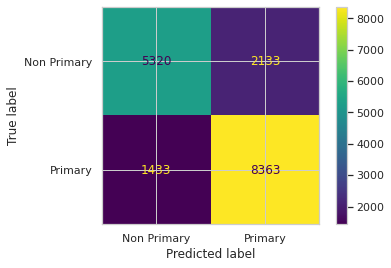

In [37]:
plot_confusion_matrix(xgb,x_train,y_train,display_labels = ['Non Primary', 'Primary'])

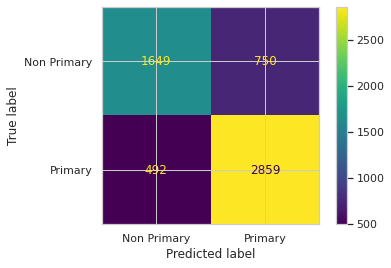

In [38]:
plot_confusion_matrix(xgb,x_test,y_test,display_labels = ['Non Primary', 'Primary'])

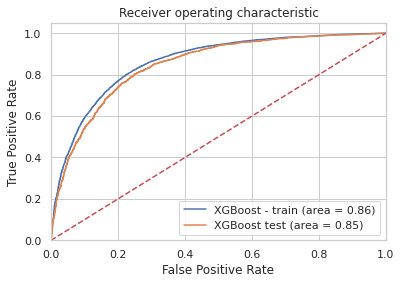

In [39]:
logit_roc_auc = roc_auc_score(y_train.to_numpy(), xgb.predict(x_train))
fpr, tpr, thresholds = roc_curve(y_train.to_numpy(), xgb.predict_proba(x_train)[:,1])
auc_train = roc_auc = auc(fpr, tpr)

logit_roc_auc = roc_auc_score(y_test, xgb.predict(x_test))
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])
auc_test = roc_auc = auc(fpr_t, tpr_t)

plt.plot(fpr, tpr, label='XGBoost - train (area = %0.2f)' % auc_train)
plt.plot(fpr_t, tpr_t, label='XGBoost test (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [40]:
explainer = shap.TreeExplainer(xgb, x_train)
shap_values = explainer.shap_values(x_test)
x_test_array = x_test.to_numpy() # we need to pass a dense version for the plotting functions

In [200]:
#shap.summary_plot(shap_values, x_test_array,x_test.columns)


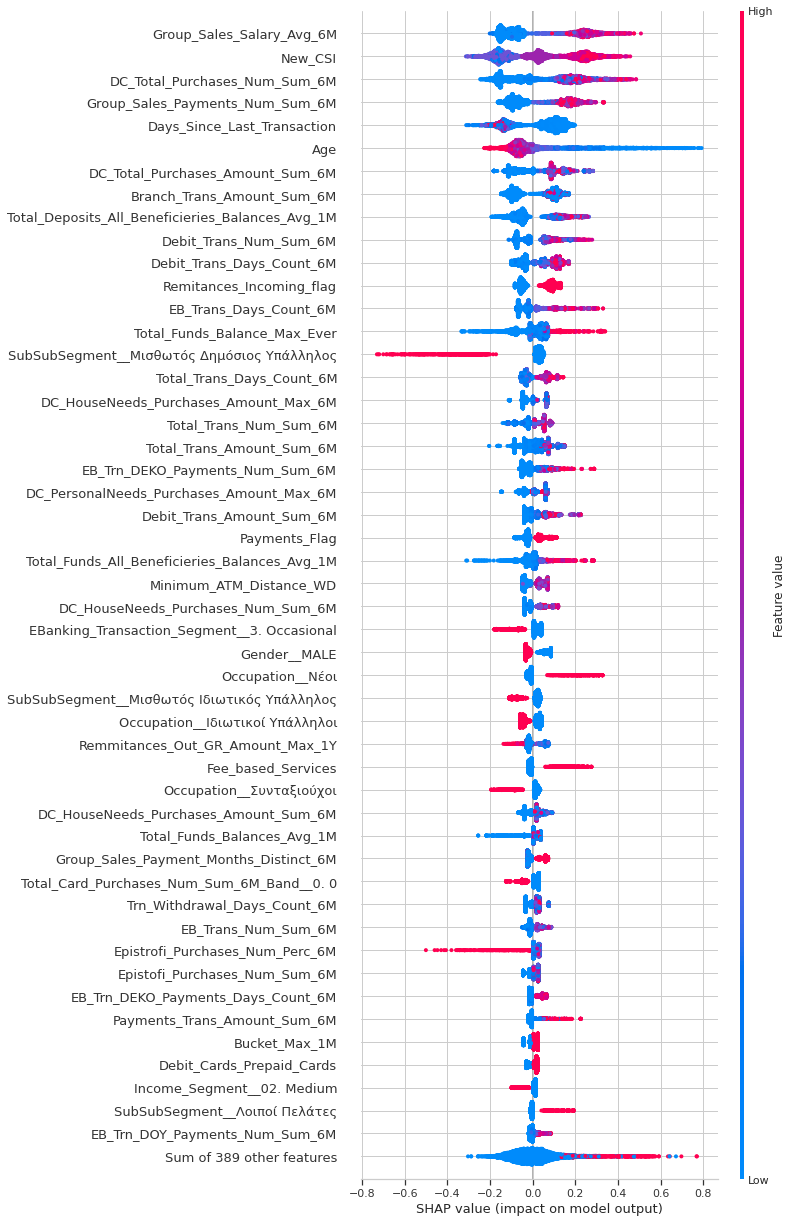

In [41]:
shap.plots.beeswarm(explainer(x_test),max_display = 50)

In [42]:
pd.set_option('display.max_rows', None)

In [43]:
important_features = pd.DataFrame(xgb.feature_importances_,x_train.columns,columns =['Importance'])\
    .sort_values(by='Importance', ascending = False).head(10).index.tolist()


In [44]:
important_features

['DC_Total_Purchases_Amount_Sum_6M',
 'Group_Sales_Payments_Num_Sum_6M',
 'DC_Total_Purchases_Num_Sum_6M',
 'New_CSI',
 'Debit_Trans_Num_Sum_6M',
 'DC_HouseNeeds_Purchases_Amount_Sum_6M',
 'Age_Band__01. le 25',
 'Debit_Trans_Days_Count_6M',
 'EB_Trans_Days_Count_6M',
 'Days_Since_Last_Transaction']